#### dependencies

In [ ]:
!pip install EMD-signal
!pip install prophet
!pip install xlrd ==2.0.1
!pip install pmdarima

In [ ]:
# !pip freeze > requirements.txt
# !pip uninstall -r requirements.txt -y

#### imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error , mean_squared_error, mean_absolute_error

In [ ]:
from PyEMD import EMD
from PyEMD import CEEMDAN
from prophet import Prophet
from pmdarima import auto_arima

# **5.Demand 2**

## 5.0 Data

In [ ]:
path ="/Datasets/nilperMonthly96_new.csv"
demand2_df = pd.read_csv(path)[:120]
demand2_ds = pd.date_range(start="2005-01-01", periods = len(demand2_df), freq="MS")
demand2_df["ds"] = demand2_ds

In [ ]:
demand2_train_set = demand2_df[:108]
demand2_test_set = demand2_df[108:]

In [ ]:
demand2_df.head()

## 5.1 Prophet

In [ ]:
dmn2_prophet = Prophet(seasonality_mode="additive")
dmn2_prophet.fit(dmn2_train_set)
dmn2_future = dmn2_prophet.make_future_dataframe(12, freq="MS")
dmn2_forecast = dmn2_prophet.predict(dmn2_future)
# dmn2_forecast.tail()

## 5.2 Prophet-EMD

### decompose

In [ ]:
emd = EMD()

In [ ]:
dmn2_imfs = emd.emd(dmn2_train_set.y.values)
dmn2_imfs.shape

(6, 108)

### + Prophet

In [ ]:
dmn2_forecast_temp=pd.DataFrame()
dmn2_forecast_temp["ds"] = dmn2_ds
dmn2_forecast_temp["yhat"] = 0

for imf in dmn2_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = dmn2_ds[:108]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(temp[:108])
  future = model.make_future_dataframe(12, freq="MS")
  dmn2_forecast = model.predict(future)
  dmn2_forecast_temp["yhat"] += dmn2_forecast['yhat']

## 5.3 Prophet-CEEMDAN

### decomposition

In [ ]:
ceemdan = CEEMDAN(spline_kind = 'akima')
dmn2_c_imfs = ceemdan.ceemdan(dmn2_train_set.y.values)

In [ ]:
dmn2_c_imfs.shape

(6, 108)

### + prophet

In [ ]:
dmn2_forecast_temp_ce=pd.DataFrame()
dmn2_forecast_temp_ce["ds"] = dmn2_ds
dmn2_forecast_temp_ce["yhat"] = 0

for imf in dmn2_c_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = dmn2_ds[:108]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(temp[:108])
  future = model.make_future_dataframe(12, freq="MS")
  dmn2_c_forecast = model.predict(future)

  dmn2_forecast_temp_ce["yhat"] += dmn2_c_forecast['yhat']

## 5.4 Prophet-ICEEMDAN

### import imfs

In [ ]:
demand2_ic_imfs = pd.read_csv("/ICEEMDAN-IMFS/IMF_demand2.csv", header=None)
demand2_ic_imfs.head()

In [ ]:
demand2_ic_imfs.shape

(6, 108)

In [ ]:
demand2_ic_imfs=demand2_ic_imfs.to_numpy()

### + prophet

In [ ]:
demand2_forecast_temp_ice=pd.DataFrame()
demand2_forecast_temp_ice["ds"] = demand_ds[:120]
demand2_forecast_temp_ice["yhat"] = 0

for imf in demand2_ic_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = demand2_ds[:108]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(temp[:108])
  future = model.make_future_dataframe(12, freq="MS")
  demand2_forecast = model.predict(future)

  demand2_forecast_temp_ice["yhat"] += demand2_forecast['yhat']

##5.5  SARIMAX

In [ ]:
dmn2_temp = dmn2_train_set.copy()
dmn2_temp.index=dmn2_ds[:108]
dmn2_temp.drop('ds', axis=1,inplace=True)
dmn2_temp

,y
2005-01-01,5999
2005-02-01,18538
2005-03-01,13516
2005-04-01,14928
2005-05-01,14337
...,...
2013-08-01,13803
2013-09-01,15493
2013-10-01,17894
2013-11-01,21313


In [ ]:
model= auto_arima(dmn2_temp, stationary=True, m=6) ## , m=12
dmn2_s_forecast = model.predict(12)

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  108
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 6)   Log Likelihood               -1035.574
Date:                           Tue, 18 Apr 2023   AIC                           2089.149
Time:                                   15:17:04   BIC                           2113.288
Sample:                               01-01-2005   HQIC                          2098.937
                                    - 12-01-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.044e+04   7445.453      1.402      0.161   -4156.652     2.5e+04
ar.L1         -0.9031      0.529     -1.708      0.088      -1.940       0.133
ma.L1          1.1087      0.541      2.049      0.040       0.048       2.169
ma.L2          0.2031      0.129      1.580      0.114      -0.049       0.455
ar.S.L6       -0.1225      0.113     -1.086      0.277      -0.343       0.099
ar.S.L12       0.7940      0.128      6.222      0.000       0.544       1.044
ma.S.L6        0.3768      0.188      2.008      0.045       0.009       0.744
ma.S.L12      -0.2632      0.224     -1.175      0.240      -0.702       0.176
sigma2      1.153e+07     15.630   7.38e+05      0.000    1.15e+07    1.15e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                 6.51
Prob(Q):                              0.42   Prob(JB):                         0.04
Heteroskedasticity (H):               1.74   Skew:                             0.47
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.97e+21. Standard errors may be unstable.
"""

# plots

## test set chart

### reading data

In [ ]:
path ="/Datasets/nilperMonthly96_new.csv"
dmn2_df = pd.read_csv(path)[:120]
dmn2_ds = pd.date_range(start="2005-01-01", periods = len(dmn2_df), freq="MS")
dmn2_df["ds"] = demand2_ds

In [ ]:
dmn2_df_p = pd.read_excel("/Forecasts/demand-2/dmn2_prophet.xlsx")
dmn2_df_p = dmn2_df_p[['ds', 'yhat']]
dmn2_df_p['ds'] = ds[: len(dmn2_df_p)]

In [ ]:
dmn2_df_ep = pd.read_excel("/Forecasts/demand-2/dmn2_Prophet-EMD.xlsx")
dmn2_df_ep = dmn2_df_ep[['ds', 'yhat']]
dmn2_df_ep['ds'] = ds[: len(dmn2_df_ep)]

In [ ]:
dmn2_df_cp = pd.read_excel("/Forecasts/demand-2/dmn2_prophet-ceemdan.xlsx")
dmn2_df_cp = dmn2_df_cp[['ds', 'yhat']]
dmn2_df_cp['ds'] = ds[: len(dmn2_df_cp)]

In [ ]:
dmn2_df_icp = pd.read_excel("/Forecasts/demand-2/dmn2_prophet-iceemdan.xlsx")
dmn2_df_icp = dmn2_df_icp[['ds', 'yhat']]
dmn2_df_icp['ds'] = ds[: len(dmn2_df_icp)]

In [ ]:
dmn2_df_s = pd.read_excel("/Forecasts/demand-2/dmn2_Sarimax.xlsx")
dmn2_df_s = dmn2_df_s[0]
dmn2_df_s.columns=['yhat']

#### plotting

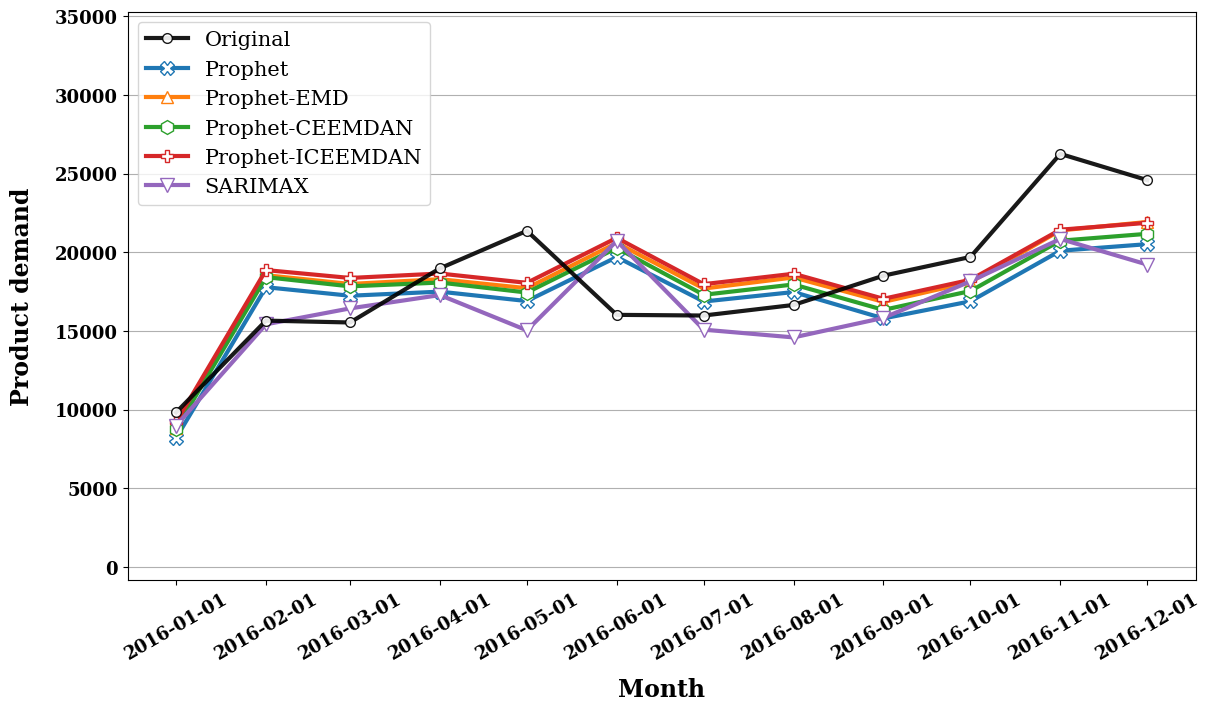

In [ ]:
plotting_test(dmn2_df, dmn2_df_p, dmn2_df_ep, dmn2_df_cp, dmn2_df_icp, dmn2_df_s, "Product demand", "Month", "demand2_test_func.jpg", 12)

## bar plot


In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] += ['Times Roman']
width = 0.1

def bar_plotter(values, title, name, tick):
  xticks = ['MAPE']
  multiplier = 0
  x = np.arange(len(xticks))

  fig, ax = plt.subplots(layout="constrained", figsize=(10,6))

  for i,j in values.items():
    offset = width * multiplier
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] += ['Times Roman']
    rects = ax.bar(x + offset, j, width, label = i)
    ax.bar_label(rects, padding=4, fontweight="bold", fontsize=13)
    multiplier+=1

  plt.legend(fontsize=13, loc="upper left")

  ax.set_xticks(x+tick, xticks, fontsize=14, fontweight="bold")
  plt.yticks(fontweight='bold', fontsize=14)

  ceil = round(max(list(values.values())) + 0.2*(max(list(values.values()))))

  plt.ylim(0, ceil)

  plt.grid(axis='y')
  ax.set_axisbelow(True)
  plt.margins(2*(1-len(values)/10), 0)
  plt.savefig(f"{name}.jpg", dpi=1200)

round


In [ ]:
def rounder(dictionary):
  for i,j in dictionary.items():
    dictionary[i] = round(j, 2)
  return(dictionary)

In [ ]:
dmn2_values = {
    # method : (MAPE)
    "Prophet":(14.34),
    "Prophet-EMD": (13.32),
    "Prophet-CEEMDAN":(13.72),
    "Prophet-ICEEMDAN":(13.48),
    "SARIMAX":(14.14),
    "Stacked-LSTM" : (12.80),
}

bar_plotter(rounder(dmn2_values), "Furniture Product Demand 2", "demand2_comparison_bar", 0.25)